# sample for xgb
https://www.kaggle.com/joaopmpeinado/talkingdata-xgboost-lb-0-966/code


[92.81129050254822] Finished to load data
[135.7963354587555] Start to generate time features
[154.75762343406677] Start XGBoost Training
[0]	train-auc:0.945787
[1]	train-auc:0.962847
[2]	train-auc:0.961722
[3]	train-auc:0.964574
[4]	train-auc:0.963511
[5]	train-auc:0.96501
[6]	train-auc:0.965758
[7]	train-auc:0.965239
[8]	train-auc:0.965235
[9]	train-auc:0.966097
[10]	train-auc:0.966531
[11]	train-auc:0.966698
[12]	train-auc:0.968141
[13]	train-auc:0.969277
[14]	train-auc:0.9696
[15]	train-auc:0.969398
[16]	train-auc:0.970113
[17]	train-auc:0.970762
[18]	train-auc:0.970976
[19]	train-auc:0.972158
[20]	train-auc:0.973181
[21]	train-auc:0.973128
[22]	train-auc:0.973022
[23]	train-auc:0.973031
[24]	train-auc:0.974322
[25]	train-auc:0.974904
[26]	train-auc:0.976052
[27]	train-auc:0.976763
[28]	train-auc:0.977101
[29]	train-auc:0.977995
[614.9711220264435] Finish XGBoost Training


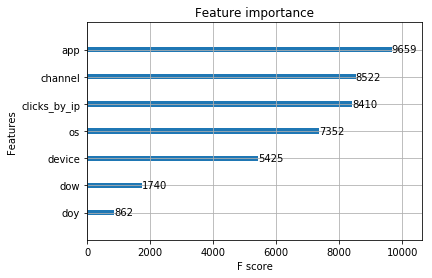

In [7]:
# This kernel have improvement from Pranav Pandya and Andy Harless
# Pranav Kernel: https://www.kaggle.com/pranav84/xgboost-on-hist-mode-ip-addresses-dropped
# Andy Kernel: https://www.kaggle.com/aharless/jo-o-s-xgboost-with-memory-usage-enhancements

import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Change this for validation with 10% from train
is_valid = False

# Check directories
from pathlib import Path
path = '../input/'
modelpath = '../model/'
subpath = '../sub/'
picpath = '../pic/'
directories = [path, modelpath, subpath, picpath]
for p in directories:
    if not(Path(p).is_dir()):
        Path(p).mkdir()

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df['doy']      = df["datetime"].dt.dayofyear
    # df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    # df['doh']      = df['datetime'].dt.hour.astype('uint8')
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv(path+"train.csv", skiprows=range(1,123903891), nrows=61000000, usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
#sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()

# Count the number of clicks by ip
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}
          

if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

# date for filename
from datetime import datetime as dt
datetime = dt.now().strftime('_%Y_%m%d_%H%M_%S')

# Plot the feature importance from xgboost
plot_importance(model)
plt.gcf().savefig(picpath + 'feature_importance_xgb' + datetime + '.png')

# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

sub['click_id'] = test['click_id'].astype('int')

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
subname = subpath + 'xgb_sub' + datetime + '.csv'
sub.to_csv(subname, float_format='%.8f', index=False)

# Save the model
modelname = modelpath + 'xgbmodel' + datetime + '.model'
model.save_model(modelname)


In [7]:
from datetime import datetime as dt
datetime = dt.now().strftime('_%Y_%m%d_%H%M_%S')
subname = 'xgb_sub' + datetime + '.csv'
subname

'xgb_sub_2018_0412_1310_13.csv'

In [6]:
from pathlib import Path
path = '../input/'
modelpath = '../model'
subpath = '../sub'
picpath = '../pic'
hogepath = '../hoge/'

Path(hogepath).is_dir()
Path(hogepath).mkdir()